# Лабораторная работа 8
---
### Упражнение 8.1
> Что случится, если при увеличении ширины гауссова окна `std` не увеличивать число элементов в окне `M`

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate
from thinkdsp import SquareSignal
from thinkdsp import SawtoothSignal
from thinkdsp import Wave
import scipy.signal

def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.windows.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

Данная функция принимаем на вход количество элементов в окне и стандартное отклонение нормального распределения (распределение Гаусса), что также является шириной гауссова окна. Сначала создается прямоугольный сигнал и сглаживает его гауссовым окном. После чего отображает на графике окно после преобразования Фурье и результат применения окна

In [3]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

Как мы можем заметить при уменьшении только ширины окна, оно начинает меньше влиять на частоты, спадая медленнее, а при увеличении наоборот. Также при увеличении `std` появляются боковые лепестки

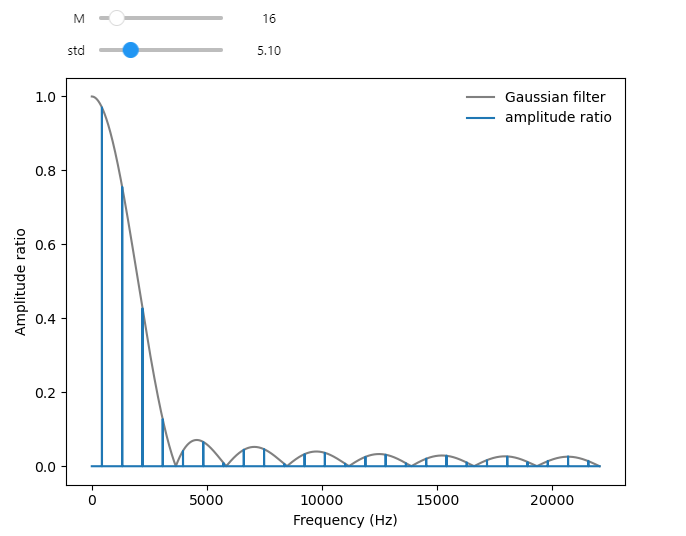

### Упражнение 8.2 

> В этой главе утверждается, что рпеобрахование Фурье гауссовой кривой - также гауссова кривая. Для дискретного преобразования Фурье это соотношение приблизительно верно.  
> Что происходит с преобраованием Фурье, если меняется `std`

Сначала построим Гауссову кривую

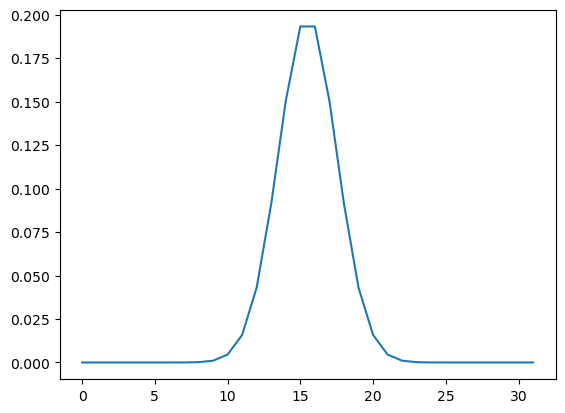

In [4]:
gaussian = scipy.signal.windows.gaussian(32, 2)
# Нормируем
gaussian /= sum(gaussian)
plt.plot(gaussian)

Теперь проведем преобразование Фурье над кривой

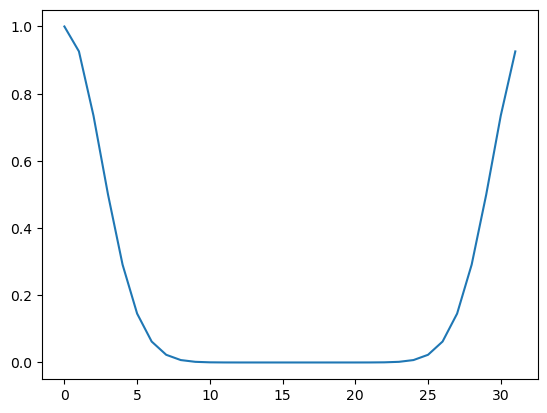

In [5]:
fft_gaussian = np.fft.fft(gaussian)
plt.plot(abs(fft_gaussian))

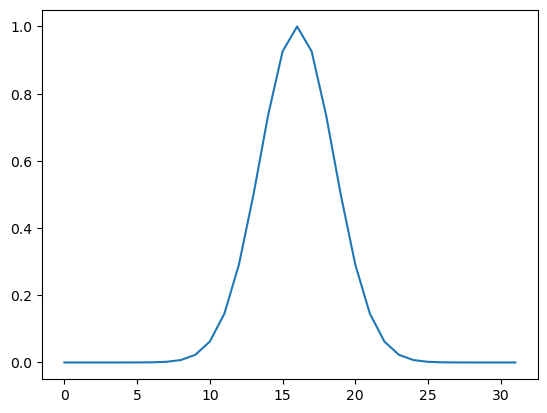

In [6]:
fft_rolled = np.roll(fft_gaussian, len(gaussian)//2)
plt.plot(abs(fft_rolled))

После перемещения полученных "отрицательных" частот в правую часть графика, получим кривую похожую на кривую нормального распределения.  

Для исследования зависимости кривых от стандартного отклонения, напишем функцию, которая будет выводить две кривые на один график и будем изменять значения с помощью виджетов

In [17]:
def plot_gauss(M, std):
    gauss = scipy.signal.windows.gaussian(M, std)
    gauss /= sum(gauss)
    fft_gauss = np.fft.fft(gauss)
    fft_rolled = np.roll(fft_gauss, len(gauss)//2)

    plt.subplot(1, 2, 1)
    plt.plot(gauss)
    decorate(xlabel='Гаусс')

    plt.subplot(1, 2, 2)
    plt.plot(abs(fft_rolled))
    decorate(xlabel='Преобразованный')

slider_M = widgets.IntSlider(min=2, max=100, value=32)
slider_std = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_gauss, M=slider_M, std=slider_std)

interactive(children=(IntSlider(value=32, description='M', min=2), FloatSlider(value=2.0, description='std', m…

<function __main__.plot_gauss(M, std)>

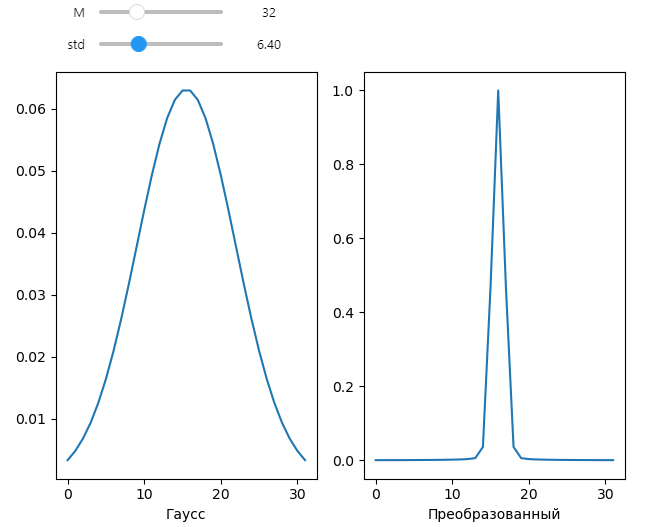

Как мы можем заметить с увеличением `std` кривая Гаусса становится шире, а ее преобразованный вариант становится уже. Можем доказать это математически.

Кривая нормального распределеняи с мат. ожиданием равным нулю и отклонением $1/\alpha$ описывается следующей функцией.
$$f(x)=e^{-\alpha x^2}$$
После преобразования Фурье получаем
$$F(x)=\sqrt{\frac{\pi}{\alpha}}e^{-\pi^2x^2/\alpha}$$

Что является гауссовой кривой с отклонением $\alpha\over\pi^2$. Следовательно между функциями существует обратная зависимость, что мы и наблюдаем

### Упражнение 8.3

> В дополнение к Гауссову окну, использованному в этой главе, создайте окно Хемминга тех же размеров. Дополните окно нулями и напечатайте его ДПФ. Какое окно больше подходит для фильтра НЧ.  
> Поэкспериментируйте с разными окнами и разными размерами этих окон

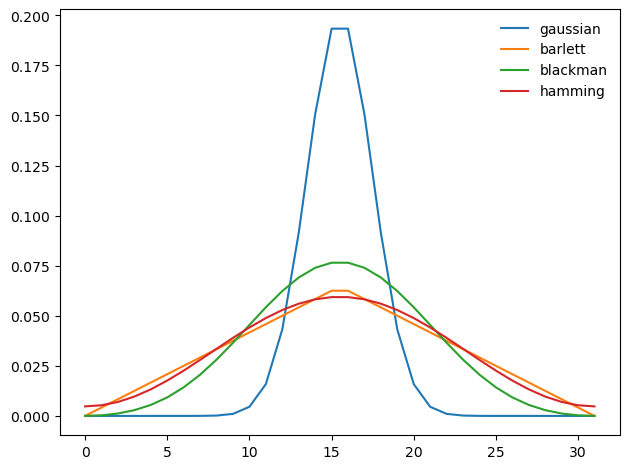

In [13]:
M = 32
std = 2

gaussian = scipy.signal.windows.gaussian(M, std)
barlett = scipy.signal.windows.bartlett(M)
hamming = scipy.signal.windows.hamming(M)
blackman = scipy.signal.windows.blackman(M)

windows = [gaussian, barlett, blackman, hamming]
names = ['gaussian', 'barlett', 'blackman', 'hamming']

for window in windows:
    window /= sum(window)

for window, name in zip(windows, names):
    plt.plot(window, label=name)

decorate()

Теперь напечатаем ДПФ окон

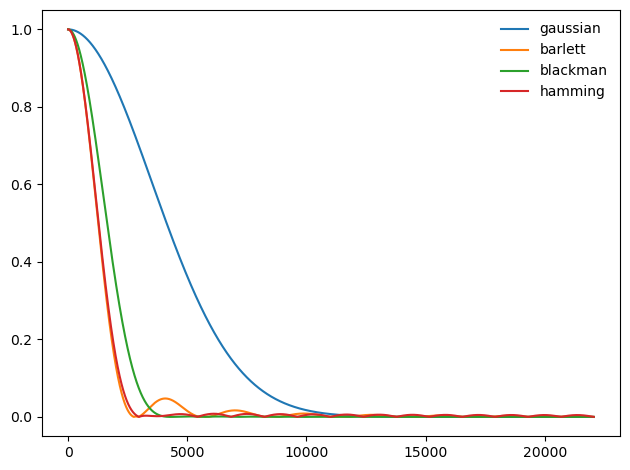

In [14]:
for window, name in zip(windows, names):
    padded = zero_pad(window, 44100)
    dft = np.fft.rfft(padded)
    plt.plot(abs(dft), label=name)

decorate()

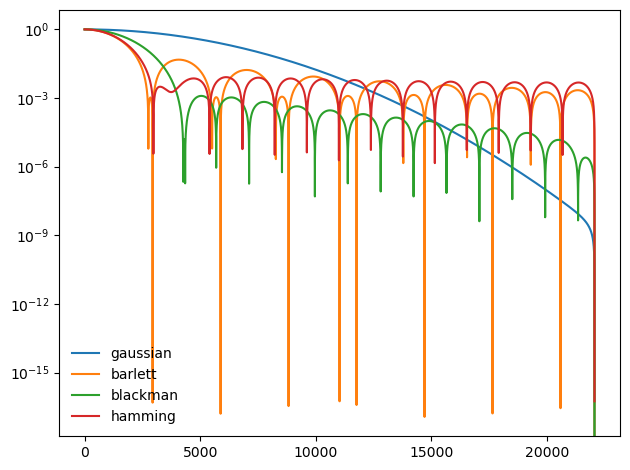

In [15]:
for window, name in zip(windows, names):
    padded = zero_pad(window, 44100)
    dft = np.fft.rfft(padded)
    plt.plot(abs(dft), label=name)

decorate(yscale='log')

Как мы можем заметить функции Барлетта и Хемминга спадают быстрее всего, что дает наибольшую фильтрацию НЧ. Таже Хемминг обладает наиболее стабильными боковыми лепестками, которые не проседают во времени